In [1]:
!pip install jsonlines
!pip install sparqlwrapper
!pip install tqdm

import json

from SPARQLWrapper import SPARQLWrapper, JSON
import jsonlines
import pandas as pd
from tqdm import tqdm

Defaulting to user installation because normal site-packages is not writeable
  Using cached jsonlines-3.1.0-py3-none-any.whl (8.6 kB)
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
  Using cached SPARQLWrapper-2.0.0-py3-none-any.whl (28 kB)
  Using cached rdflib-6.2.0-py3-none-any.whl (500 kB)
  Using cached isodate-0.6.1-py2.py3-none-any.whl (41 kB)
  Using cached pyparsing-3.0.9-py3-none-any.whl (98 kB)
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.


# Analyze Wikidata gender distribution

In [33]:
entity_path = "../../wikidata_humans/wikidata_all_human_entities.jsonl"

In [34]:
with open(entity_path) as json_file:
    ent_list = list(json_file)
    print(len(ent_list))

10211951


In [35]:
ids = []
genders = []
dobs = []
pobs = []
with open(entity_path) as json_file:
    ent_list = list(json_file)

for entry in ent_list:
      entry = json.loads(entry)
      ids += [entry["entity_id"]]
      genders += [entry["gender"]]
      dobs += [entry["DOB"]]
      pobs += [entry["POB"]]


### a) Load gender map from json

In [36]:
with open("wikidata_genders.json", "r") as f:
    gender_map = json.load(f)["map"]

### b) Create gender map through SPARQL queries

In [ ]:
user_agent = 'AngelieKraftUHH (angelie.kraft@uni-hamburg.de)'
sparql = SPARQLWrapper("https://query.wikidata.org/sparql", agent=user_agent)

In [ ]:
gender_map = {}
for g in list(set(genders)):
    sparql.setQuery(f"""
    SELECT  *
    WHERE 
    {{
        wd:{g} rdfs:label ?label .
        FILTER (langMatches( lang(?label), "EN" ) )
    }}
    """)
    sparql.setReturnFormat(JSON)
    query_result = sparql.query().convert()

    try:
        gender_map[g] = query_result["results"]["bindings"][0]["label"]["value"]
    except:
        pass
  

In [ ]:
gender_map[""] = "unknown"

### Compute frequencies

In [37]:
from collections import Counter

genders_decoded = [gender_map[g] for g in genders]
gender_frequencies = dict(Counter(genders_decoded))
gender_frequencies

{'male': 6140593,
 'female': 1988367,
 'trans woman': 1387,
 'unknown': 2080255,
 'non-binary': 588,
 'trans man': 310,
 'intersex': 76,
 'faʻafafine': 5,
 'hijra': 3,
 'eunuch': 142,
 'agender': 19,
 'androgyne': 3,
 'genderqueer': 39,
 'undisclosed gender': 1,
 'transgender': 24,
 'genderfluid': 44,
 'travesti': 4,
 'cisgender female': 21,
 'two-spirit': 16,
 'transmasculine': 8,
 'bigender': 6,
 'assigned male at birth': 1,
 'neutrois': 4,
 'indefinite': 1,
 'takatāpui': 3,
 'female organism': 5,
 'transfeminine': 6,
 'Jamaica': 1,
 'neutral sex': 5,
 'muxe': 2,
 'intersex person': 3,
 'pangender': 1,
 'queer': 1,
 'Alien': 1,
 'māhū': 1,
 'X-gender': 1,
 'demiboy': 1,
 "'akava'ine": 1,
 'vakasalewalewa': 1,
 'third gender': 1}

### Group certain gender groups for visualization

In [38]:
keys = ["female", "male", "unknown", "non-binary/agender/other"]
grouped_frequencies = dict(zip(keys, [0]*len(keys)))
for k,v in gender_frequencies.items():
    if k in ["trans man", "male"]:
        grouped_frequencies["male"] += v
    elif k in ["trans woman", "female", "cisgender female"]:
        grouped_frequencies["female"] += v
    elif k in ["unknown", "undisclosed gender"]:
        grouped_frequencies["unknown"] += v
    else:
        grouped_frequencies["non-binary/agender/other"] += v

In [39]:
grouped_frequencies = {"unknown": grouped_frequencies["unknown"], "male": grouped_frequencies["male"], "non-binary/agender/other": grouped_frequencies["non-binary/agender/other"], "female": grouped_frequencies["female"]}

In [ ]:
sum(grouped_frequencies.values())

In [15]:

!pip install matplotlib seaborn
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

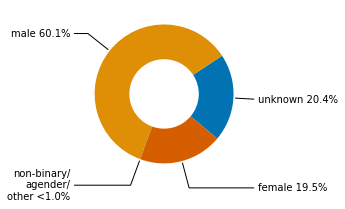

In [40]:
fig, ax = plt.subplots(figsize=(6, 3), subplot_kw=dict(aspect="equal"))
total = sum(grouped_frequencies.values())
labels = ["/\n".join(k.split("/")) for k, v in grouped_frequencies.items()]

def my_autopct(pct):
    return ('%.1f' % pct) + "%" if pct > 1 else '<1.0%'
explode = (0, 0, 0, 0.2, 0.2, 0.2)
#plt.pie(grouped_frequencies.values(), labels=labels,  explode=[0.10]*len(grouped_frequencies), autopct=my_autopct)
wedges, texts  = ax.pie(grouped_frequencies.values(), wedgeprops=dict(width=0.5), startangle=-40, colors=sns.color_palette("colorblind"))

kw = dict(arrowprops=dict(arrowstyle="-"), va="center")

for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = "angle,angleA=0,angleB={}".format(ang)
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    ax.annotate(f"{labels[i]} {my_autopct(list(grouped_frequencies.values())[i] / total * 100)}", xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y),
                horizontalalignment=horizontalalignment, **kw)

#plt.legend(patches, labels, loc='left center', bbox_to_anchor=(-0.1, 1.),
#           fontsize=8)
plt.savefig('wikidata_gender_distr_Oct2022.png', dpi=300)
plt.tight_layout()
plt.show()

In [ ]:
save_dict = {}
save_dict["map"] = gender_map
save_dict["frequencies"] = gender_frequencies
save_dict["grouped_frequencies"] = grouped_frequencies

with open("wikidata_genders.json", "w") as f:
    json.dump(save_dict, f)

# Analyze bias in KELM entities

In [9]:
kelm_wikidata_matched_path = "../../wikidata_humans/kelm_person_entities_matched_genders.jsonl"

In [10]:
with open(kelm_wikidata_matched_path) as json_file:
    kelm_ent_list = list(json_file)

In [70]:
keys = ["female", "trans woman", "male",  "trans man", "unknown", "non-binary/agender/other"]
kelm_grouped_frequencies = dict(zip(keys, [0]*len(keys)))
#gender_df = pd.DataFrame()
for i, ent in enumerate(tqdm(kelm_ent_list)):
    ent_unpacked = json.loads(ent)
    g = ent_unpacked["gender"]
    #gender_df.loc[i, ["id", "gender"]] = ent_unpacked["id"], g
    if g in ["female", "cisgender female"]:
        kelm_grouped_frequencies["female"] += 1
    elif g in ["unknown", "undisclosed gender"]:
        kelm_grouped_frequencies["unknown"] += 1
    elif g in ["male", "trans woman", "trans man"]:
        kelm_grouped_frequencies[g] += 1
    else:
        kelm_grouped_frequencies["non-binary/agender/other"] += 1

 22%|██▏       | 398648/1811976 [42:43<2:31:28, 155.50it/s]


In [ ]:
sns.countplot(x=gender_df["gender"])

In [12]:
kelm_grouped_frequencies

{'female': 342724,
 'male': 1466593,
 'unknown': 2280,
 'non-binary/agender/other': 379}

In [13]:
for k, v in kelm_grouped_frequencies.items():
    print(k, v / 1811976)

female 0.1891437855689038
male 0.8093887557009585
unknown 0.0012582948118518126
non-binary/agender/other 0.0002091639182858934


In [59]:
kelm_grouped_frequencies = {k: v for k, v in sorted(kelm_grouped_frequencies.items(), key=lambda item: item[1], reverse=True)}

In [60]:
df = pd.DataFrame()
for k, v in kelm_grouped_frequencies.items():
    df.loc[0,k] = v
df

,male,female,unknown,non-binary/agender/other
0,1466593.0,342724.0,2280.0,379.0


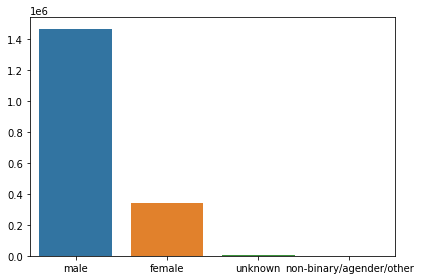

In [69]:
sns.countplot(df)
plt.tight_layout()


In [21]:
kelm_grouped_frequencies = {"unknown": kelm_grouped_frequencies["unknown"], "male": kelm_grouped_frequencies["male"], "non-binary/agender/other": kelm_grouped_frequencies["non-binary/agender/other"], "female": kelm_grouped_frequencies["female"]}

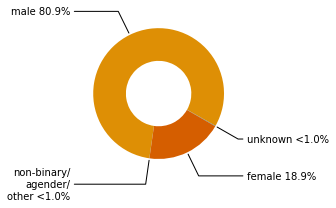

In [25]:
fig, ax = plt.subplots(figsize=(6, 3), subplot_kw=dict(aspect="equal"))
total = sum(kelm_grouped_frequencies.values())
labels = ["/\n".join(k.split("/")) for k, v in kelm_grouped_frequencies.items()]
#labels = list(grouped_frequencies.keys())
#sns.set(rc={'axes.facecolor':'black', 'figure.facecolor':'white'})
def my_autopct(pct):
    return ('%.1f' % pct) + "%" if pct > 1 else '<1.0%'
explode = (0, 0, 0, 0.2, 0.2, 0.2)
#plt.pie(grouped_frequencies.values(), labels=labels,  explode=[0.10]*len(grouped_frequencies), autopct=my_autopct)
wedges, texts  = ax.pie(kelm_grouped_frequencies.values(), wedgeprops=dict(width=0.5), startangle=-30, colors=sns.color_palette("colorblind"))

kw = dict(arrowprops=dict(arrowstyle="-"), va="center")

for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = "angle,angleA=0,angleB={}".format(ang)
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    ax.annotate(f"{labels[i]} {my_autopct(list(kelm_grouped_frequencies.values())[i] / total * 100)}", xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y),
                horizontalalignment=horizontalalignment, **kw)

#plt.legend(patches, labels, loc='left center', bbox_to_anchor=(-0.1, 1.),
#           fontsize=8)
plt.savefig('kelm_gender_distr.png', dpi=300)
plt.tight_layout()
plt.show()

KELM Entities: 6902305 (all incl. non-persons)
Wikidata Entities: 10211951 (only persons)

In [ ]:
entity_path = "../../kelm/entities.jsonl"
with open(entity_path) as json_file:
    ent_list = list(json_file)

q_count = 0
for e in tqdm(ent_list):
    id = json.loads(e)["id"]
    if id.startswith("Q"):
        q_count += 1


# Analysis of KELM texts

In [2]:
kelm_path = "../../kelm/kelm_generated_corpus.jsonl"

In [59]:
with open(kelm_path, encoding='utf8') as json_file:
    kelm_list = list(json_file)

In [111]:
kelm_list[242]

'{"triples": [["Plave\\u010d ( Znojmo District )", "described by source", "Ott\\u016fv slovn\\u00edk nau\\u010dn\\u00fd"]], "serialized_triples": "Plave\\u010d ( Znojmo District ) described by source Ott\\u016fv slovn\\u00edk nau\\u010dn\\u00fd.", "gen_sentence": "Plave \\u2047  (Znojmo District) was described in Ott \\u2047 v slovn \\u2047 k nau \\u2047 n \\u2047 ."}\n'

In [112]:
json.loads(kelm_list[242])

{'triples': [['Plaveč ( Znojmo District )',
   'described by source',
   'Ottův slovník naučný']],
 'serialized_triples': 'Plaveč ( Znojmo District ) described by source Ottův slovník naučný.',
 'gen_sentence': 'Plave ⁇  (Znojmo District) was described in Ott ⁇ v slovn ⁇ k nau ⁇ n ⁇ .'}

In [61]:
selected_sentences = []
for entry in kelm_list[:500]:
    selected_sentences += [json.loads(entry).encode('utf-8').decode('utf-8')["gen_sentence"]]

In [50]:
selected_sentences

['Valentin Lavigne played for FC Lorient between 2014 and 2016.',
 'Daimon Station (Aichi) is located adjacent to Kitano Masuzuka Station which is located towards K ⁇ z ⁇ ji Station.',
 'Gharbia Governorate has a population of 4999633.',
 'Fazl Rural District (Hamadan Province) is located in the Zarrin Dasht District, Iran.',
 'Crataegus erythropoda is a taxon of Crataegus, a species of hawthorn.',
 'The Government Commission for Higher Education is part of the Norwegian Official Report.',
 'Eista Werf produces doerak.',
 'The Molli railway is located at Bad Doberan.',
 'John Thomson, born 1896, started his career in 1924 with Aberdare Athletic FC.',
 'Grzegorz Piechna is a member of the FC Spartak Varna soccer team.',
 'Lalita Yauhleuskaya competed at the 2008 Summer Olympics.',
 'Cyprus competed at the 2015 European Games in Baku, Azerbaijan.',
 'The patronage number of Trabzon Airport is 2620887.',
 'Jack Horsley graduated from Indiana University Bloomington.',
 'Mogi ⁇ a is a Szlac

In [31]:
import locale

locale.getpreferredencoding()


'UTF-8'

In [51]:
selected_sentences[242] #.encode('utf-8').decode('utf-8')

'Plave ⁇  (Znojmo District) was described in Ott ⁇ v slovn ⁇ k nau ⁇ n ⁇ .'